# 공유오피스 데이터 분석 (머신러닝)
    - 공유오피스 데이터 기반 데이터 분석

## 분석 목표
    - 유저의 방문기록을 바탕으로 최종 결제를 진행했는지에 대한 모델링
    - 이를 통한 비즈니스 전략을 제안하는 것이 목표

## 환경설정

In [1]:
# ▶ 한글 폰트 설정하기
# !pip install koreanize-matplotlib -q

import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

import warnings
warnings.filterwarnings("ignore")

## 데이터 불러오기

In [2]:
site_area = pd.read_csv('data/site_area.csv')
trial_access_log = pd.read_csv('data/trial_access_log.csv')
trial_payment = pd.read_csv('data/trial_payment.csv')
trial_register = pd.read_csv('data/trial_register.csv')
trial_visit_info = pd.read_csv('data/trial_visit_info.csv')

## 한국시간으로 변환

In [3]:
# UTC → KST 변환 함수
def convert_utc_to_kst(df, column):
    if column in df.columns:
        df[column] = pd.to_datetime(df[column], errors='coerce', utc=True).dt.tz_convert('Asia/Seoul')
    return df

# 컬럼별 변환 적용
# trial_visit_info: first_enter_time, last_leave_time
trial_visit_info = convert_utc_to_kst(trial_visit_info, "first_enter_time")
trial_visit_info = convert_utc_to_kst(trial_visit_info, "last_leave_time")

# trial_access_log: cdate
trial_access_log = convert_utc_to_kst(trial_access_log, "cdate")
trial_access_log = convert_utc_to_kst(trial_access_log, "open_date")

# trial_register: datetime 컬럼명 확인 후 변환 (예: register_datetime 또는 신청일 등)
trial_register = convert_utc_to_kst(trial_register, "register_datetime")  # 해당 컬럼 존재 시 적용

## 기본 EDA

### trial_register (3일체험 신청)

- 총 9,659건의 신청 중, 9,421명이 유일한 사용자
- 중복 신청 유저 35명
	- 같은 날 2회 신청 -> 전산 오류
		- 28명
		- user_uuid 기준으로 trial_date 중복 제거
	- 다른 날 2회 신청 -> 재신청 케이스
		- 7명
		- 첫 신청 후 실제 방문하지 않고, 재신청을 통해 이용한 케이스로 보임
			- 가장 최근 신청 기준으로 1건만 남김

In [4]:
trial_register.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9659 entries, 0 to 9658
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   trial_date  9659 non-null   object
 1   user_uuid   9659 non-null   object
dtypes: object(2)
memory usage: 151.1+ KB


In [5]:
trial_register['user_uuid'].nunique()

9624

In [6]:
# 1. 중복 신청한 유저만 추출
dupe_users = trial_register[trial_register['user_uuid'].duplicated(keep=False)]

# 2. 유저별 신청일 수 계산
user_trial_dates = dupe_users.groupby('user_uuid')['trial_date'].nunique().reset_index(name='unique_dates')

# 3. 같은 날 중복 신청자
same_day_users = user_trial_dates[user_trial_dates['unique_dates'] == 1]['user_uuid']
same_day_duplicates = dupe_users[dupe_users['user_uuid'].isin(same_day_users)]

# 4. 서로 다른 날 중복 신청자
diff_day_users = user_trial_dates[user_trial_dates['unique_dates'] > 1]['user_uuid']
diff_day_duplicates = dupe_users[dupe_users['user_uuid'].isin(diff_day_users)]

# 5. 건수 출력
print("✅ 같은 날 2회 신청")
print(f" - 유저 수: {same_day_users.nunique()}")
print(f" - 중복 신청 건수: {same_day_duplicates.shape[0]}")

print("\n✅ 서로 다른 날에 2회 신청")
print(f" - 유저 수: {diff_day_users.nunique()}")
print(f" - 중복 신청 건수: {diff_day_duplicates.shape[0]}")


✅ 같은 날 2회 신청
 - 유저 수: 28
 - 중복 신청 건수: 56

✅ 서로 다른 날에 2회 신청
 - 유저 수: 7
 - 중복 신청 건수: 14


In [7]:
# trial_visit_info는 이미 불러온 상태이므로 복사본 사용
visit_info = trial_visit_info.copy()
visit_info['date'] = pd.to_datetime(visit_info['date'])

# diff_day_duplicates에 해당하는 유저들의 최근 신청일 구하기
dupe_users = trial_register[trial_register['user_uuid'].duplicated(keep=False)]
user_trial_dates = dupe_users.groupby('user_uuid')['trial_date'].nunique().reset_index(name='unique_dates')
diff_day_users = user_trial_dates[user_trial_dates['unique_dates'] > 1]['user_uuid']
diff_day_duplicates = dupe_users[dupe_users['user_uuid'].isin(diff_day_users)]

# 날짜 변환
diff_day_duplicates['trial_date'] = pd.to_datetime(diff_day_duplicates['trial_date'])
latest_trials = diff_day_duplicates.sort_values('trial_date').drop_duplicates('user_uuid', keep='last')

# 해당 유저들의 최근 신청일 이전 이용기록이 있는지 확인
latest_trials = latest_trials.rename(columns={'trial_date': 'latest_trial_date'})
visit_info_check = pd.merge(visit_info, latest_trials, on='user_uuid', how='inner')

# 최근 신청일 이전에 방문 기록이 있는 유저만 필터링
prior_visit_exists = visit_info_check[visit_info_check['date'] < visit_info_check['latest_trial_date']]['user_uuid'].unique()

# 총 중복 유저 수 대비 비율
total_diff_day_users = latest_trials['user_uuid'].nunique()
prior_visit_count = len(prior_visit_exists)

{
    "서로 다른 날 중복 신청 유저 수": total_diff_day_users,
    "최근 신청일 이전에 방문 기록이 있는 유저 수": prior_visit_count,
    "비율 (%)": round((prior_visit_count / total_diff_day_users) * 100, 2)
}

{'서로 다른 날 중복 신청 유저 수': 7, '최근 신청일 이전에 방문 기록이 있는 유저 수': 0, '비율 (%)': 0.0}

#### trial_register 오류값 처리

- 중복 신청 유저 35명
	- 같은 날 2회 신청 -> 전산 오류
		- 28명
		- user_uuid 기준으로 trial_date 중복 제거
	- 다른 날 2회 신청 -> 재신청 케이스
		- 7명
		- 첫 신청 후 실제 방문하지 않고, 재신청을 통해 이용한 케이스로 보임
			- 가장 최근 신청 기준으로 1건만 남김

In [8]:
trial_register_cleaned = trial_register.drop_duplicates(subset=['user_uuid', 'trial_date'])
trial_register_cleaned  = trial_register_cleaned.sort_values('trial_date').drop_duplicates(subset=['user_uuid'], keep='last')

In [9]:
trial_register_cleaned['user_uuid'].nunique()

9624

#### 신청월별 평균 체류시간 비교 (결제자 vs 비결제자)

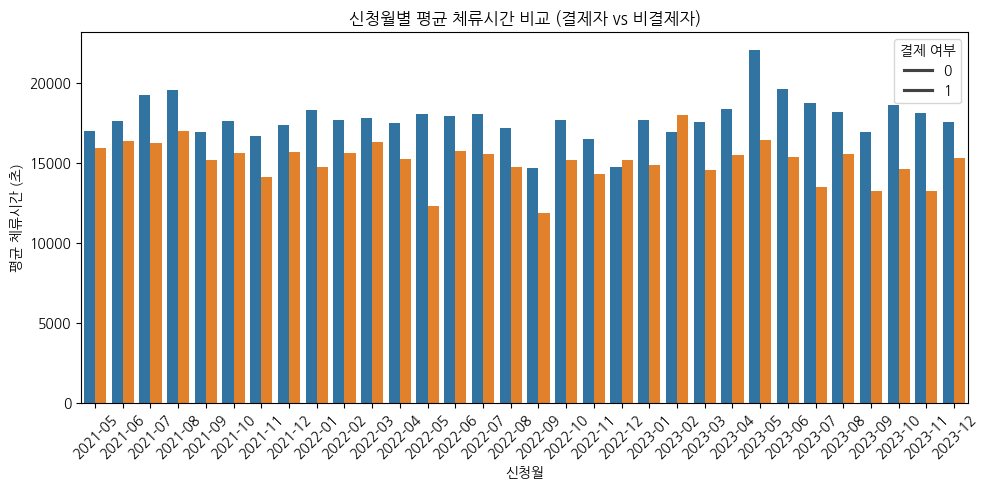

In [10]:
# trial_register_cleaned 불러오기
trial_register_cleaned['trial_date'] = pd.to_datetime(trial_register_cleaned['trial_date'])

# 결제 여부 정보 병합
register_with_payment = pd.merge(trial_register_cleaned, trial_payment, on='user_uuid', how='left')

# 방문 기록과 병합
visit_info = trial_visit_info.copy()
visit_info['date'] = pd.to_datetime(visit_info['date'])

# 체류시간 집계를 위해 신청일 기준으로 visit과 매핑
register_visit_merged = pd.merge(visit_info, register_with_payment, on='user_uuid', how='inner')

# 신청한 달 계산
register_visit_merged['신청월'] = register_visit_merged['trial_date'].dt.to_period('M').astype(str)

# 유저별 신청월 + 결제여부에 따른 체류시간 평균 집계
stay_summary = register_visit_merged.groupby(['신청월', 'is_payment'])['stay_time_second'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(
    data=stay_summary,
    x='신청월',
    y='stay_time_second',
    hue=stay_summary['is_payment']
)
plt.title('신청월별 평균 체류시간 비교 (결제자 vs 비결제자)')
plt.xlabel('신청월')
plt.ylabel('평균 체류시간 (초)')
plt.legend(title='결제 여부', labels=[0, 1])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
print(stay_summary[stay_summary['is_payment'] == 1]['stay_time_second'].median())

print(stay_summary[stay_summary['is_payment'] == 0]['stay_time_second'].median())

15305.479238555326
17699.663036591162


- 비결제자는 대부분의 달에서 결제자보다 평균 체류시간이 더 길었습니다.

### trial_visit_info (3일체험 신청자 일자별 방문기록)

In [12]:
trial_visit_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11477 entries, 0 to 11476
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype                     
---  ------            --------------  -----                     
 0   site_id           11477 non-null  int64                     
 1   date              11477 non-null  object                    
 2   stay_time         11477 non-null  object                    
 3   stay_time_second  11477 non-null  int64                     
 4   first_enter_time  10124 non-null  datetime64[ns, Asia/Seoul]
 5   last_leave_time   10147 non-null  datetime64[ns, Asia/Seoul]
 6   user_uuid         11477 non-null  object                    
dtypes: datetime64[ns, Asia/Seoul](2), int64(2), object(3)
memory usage: 627.8+ KB


In [13]:
trial_visit_info['user_uuid'].nunique()

6534

In [14]:
trial_access_log['user_uuid'].nunique()

6026

In [15]:
trial_payment[trial_payment['is_payment'] == 1].nunique()

is_payment       1
user_uuid     3652
dtype: int64

In [16]:
trial_visit_info['user_uuid'].nunique()

6534

In [17]:
# stay_time이 30초 이하인 경우
very_short = visit_info[visit_info['stay_time_second'] <= 30]

# stay_time이 24시간(86400초) 이상인 경우
very_long = visit_info[visit_info['stay_time_second'] >= 86400]

# 건수 요약
{
    "30초 이하 체류 건수": len(very_short),
    "24시간 이상 체류 건수": len(very_long)
}

{'30초 이하 체류 건수': 16, '24시간 이상 체류 건수': 0}

#### 체류시간 분포

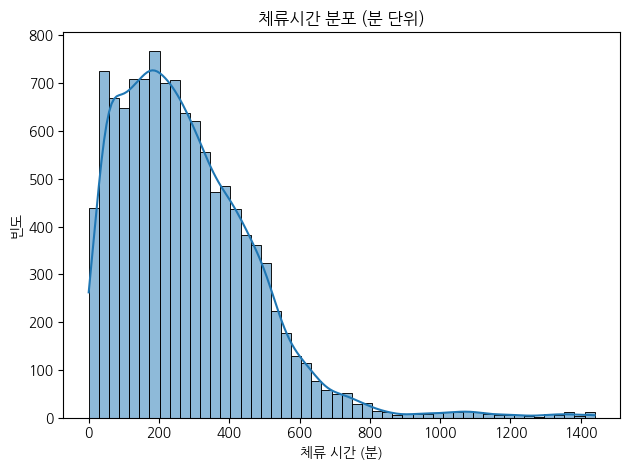

In [18]:
# 시각화를 위한 데이터 복사본 생성
eda_df = trial_visit_info.copy()

# 날짜 컬럼 변환
eda_df['date'] = pd.to_datetime(eda_df['date'])
eda_df['weekday'] = eda_df['date'].dt.day_name()
eda_df['month'] = eda_df['date'].dt.to_period('M')

# 체류 시간 분 단위로 변환
eda_df['stay_minutes'] = eda_df['stay_time_second'] / 60

# 체류시간 분포
fig1, ax1 = plt.subplots()
sns.histplot(eda_df['stay_minutes'], bins=50, kde=True, ax=ax1)
ax1.set_title('체류시간 분포 (분 단위)')
ax1.set_xlabel('체류 시간 (분)')
ax1.set_ylabel('빈도')

plt.tight_layout()
plt.show()

- 대부분의 이용자는 30분에서 3시간 사이에 체류하는 것으로 나타났습니다.
- 일부 이용자는 4시간 이상 장시간 체류하는 경우도 있었습니다.

#### 요일별 방문 수

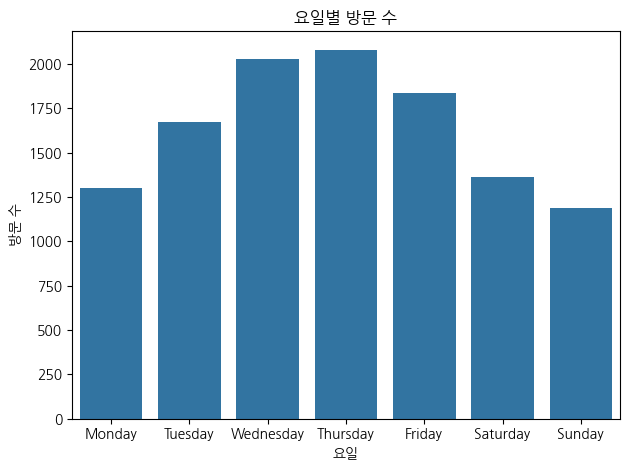

In [19]:
fig2, ax2 = plt.subplots()
sns.countplot(x='weekday', data=eda_df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ax=ax2)
ax2.set_title('요일별 방문 수')
ax2.set_xlabel('요일')
ax2.set_ylabel('방문 수')

plt.tight_layout()
plt.show()

- 화요일부터 금요일까지 방문자가 많았으며, 주말에는 상대적으로 적은 편이었습니다.
	- 평일 중심으로 서비스가 주로 이용되고 있는 것으로 해석됩니다.


#### 월별 방문 수

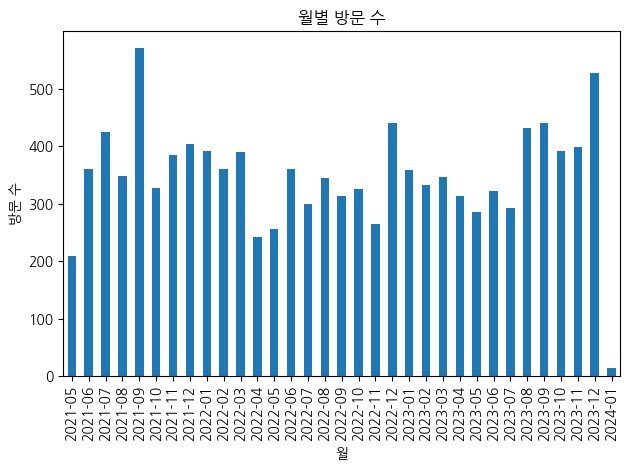

In [20]:
monthly_counts = eda_df['month'].value_counts().sort_index()
fig3, ax3 = plt.subplots()
monthly_counts.plot(kind='bar', ax=ax3)
ax3.set_title('월별 방문 수')
ax3.set_xlabel('월')
ax3.set_ylabel('방문 수')

plt.tight_layout()
plt.show()

#### 지점별 평균 체류 시간

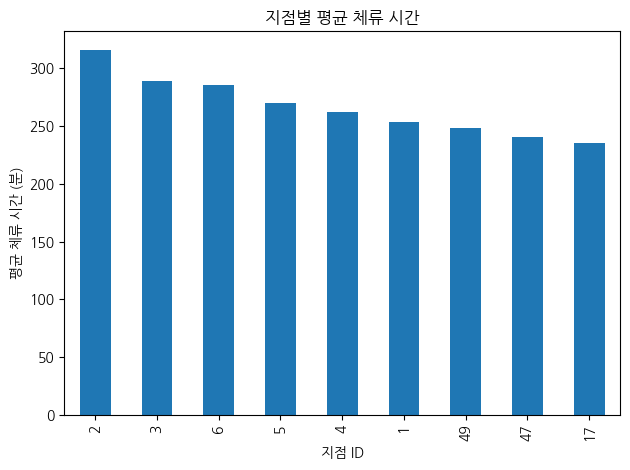

In [21]:
site_mean_stay = eda_df.groupby('site_id')['stay_minutes'].mean().sort_values(ascending=False)
fig4, ax4 = plt.subplots()
site_mean_stay.plot(kind='bar', ax=ax4)
ax4.set_title('지점별 평균 체류 시간')
ax4.set_xlabel('지점 ID')
ax4.set_ylabel('평균 체류 시간 (분)')

plt.tight_layout()
plt.show()

### trial_access_log (3일체험 신청자 출입기록)

In [22]:
trial_access_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63708 entries, 0 to 63707
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype                     
---  ------     --------------  -----                     
 0   id         63708 non-null  int64                     
 1   checkin    63708 non-null  int64                     
 2   cdate      63708 non-null  datetime64[ns, Asia/Seoul]
 3   site_id    63708 non-null  int64                     
 4   user_uuid  63708 non-null  object                    
dtypes: datetime64[ns, Asia/Seoul](1), int64(3), object(1)
memory usage: 2.4+ MB


In [23]:
# 전처리: datetime 변환, 입퇴실 이름 지정
trial_access_log['cdate'] = pd.to_datetime(trial_access_log['cdate'])
trial_access_log['hour'] = trial_access_log['cdate'].dt.hour
trial_access_log['weekday'] = trial_access_log['cdate'].dt.day_name()
trial_access_log['date'] = trial_access_log['cdate'].dt.date

# 입실/퇴실 코드 해석
checkin_map = {1: 'IN', 2: 'OUT'}
trial_access_log['checkin_type'] = trial_access_log['checkin'].map(checkin_map)

# 입실/퇴실 비율
in_out_counts = trial_access_log['checkin_type'].value_counts()

# 요일별 출입 로그 수
weekday_counts = trial_access_log['weekday'].value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

# 시간대별 출입 로그 수
hourly_counts = trial_access_log['hour'].value_counts().sort_index()

#### 입실 및 퇴실 로그 수 비교

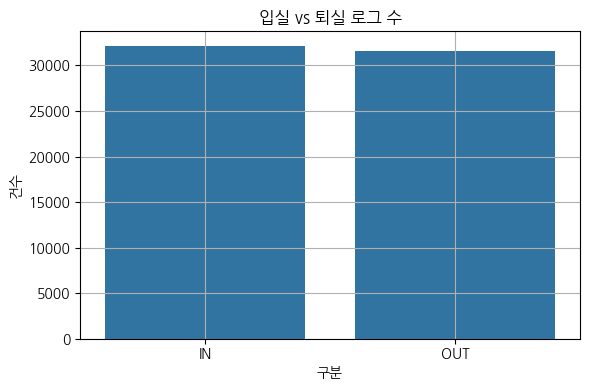

In [24]:
# 입실 vs 퇴실 로그 수
plt.figure(figsize=(6, 4))
sns.barplot(x=in_out_counts.index, y=in_out_counts.values)
plt.title("입실 vs 퇴실 로그 수")
plt.xlabel("구분")
plt.ylabel("건수")
plt.grid(True)
plt.tight_layout()
plt.show()

- 두 값은 거의 동일하나, 입실 로그(IN)가 퇴실 로그(OUT)보다 약간 더 많습니다.

#### 시간대별 출입 로그 수

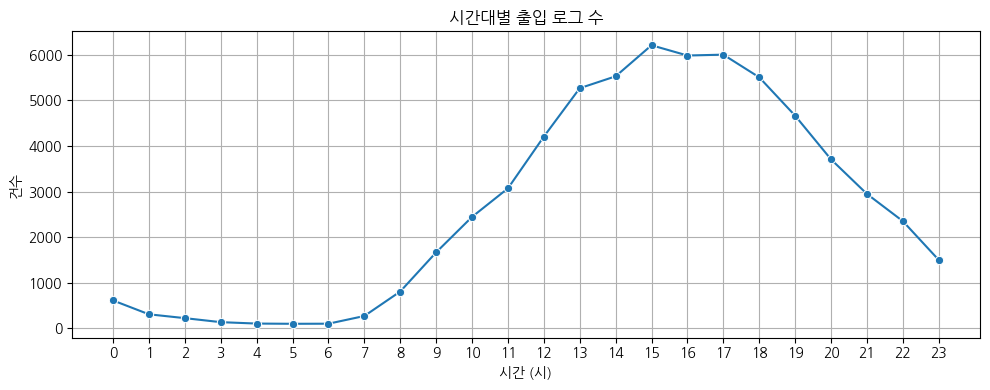

In [25]:
plt.figure(figsize=(10, 4))
sns.lineplot(x=hourly_counts.index, y=hourly_counts.values, marker="o")
plt.title("시간대별 출입 로그 수")
plt.xlabel("시간 (시)")
plt.ylabel("건수")
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

- 오전 9시부터 출입이 급증
    - 오전 9시부터 출입 로그가 본격적으로 증가하며, 오후 3시(15시)에 최대치(약 6,200건 이상)를 기록합니다.

- 오후 4시~6시까지도 높은 이용 유지
    - 오후 16시~18시에도 많은 출입이 유지되고 있어, 장시간 체류하거나 오후 타임 미팅 등으로 이용이 지속되는 것으로 보입니다.

- 저녁 이후 점차 감소
    - 19시 이후부터 출입 수가 점차 감소하며, 22시~23시에 이르면 대부분의 이용이 마무리되는 패턴을 보입니다.

- 심야 시간대는 매우 낮은 출입
    - 0시~6시 사이에는 출입 로그가 거의 없어, 이 시간대는 사실상 서비스 이용이 거의 없는 비활성 시간대로 판단됩니다.



#### 지점별 운영 기간(출입 로그 기준) 확인

In [26]:
trial_access_log['cdate'] = pd.to_datetime(trial_access_log['cdate'])

# 지점별 이용 시작일과 종료일 구하기
site_periods = trial_access_log.groupby("site_id")["cdate"].agg(["min", "max"]).reset_index()
site_periods.columns = ["site_id", "start_date", "end_date"]

site_periods

,site_id,start_date,end_date
0,1,2021-05-03 14:20:36.931652+09:00,2023-12-30 19:41:24.360807+09:00
1,2,2021-05-06 14:48:22.282740+09:00,2023-12-31 00:30:23.735595+09:00
2,3,2021-05-02 18:42:13.893455+09:00,2024-01-01 23:36:13.987243+09:00
3,4,2021-05-12 09:34:48.235545+09:00,2024-01-01 18:38:05.941027+09:00
4,5,2021-09-03 10:00:16.574002+09:00,2023-10-14 21:31:26.409452+09:00
5,6,2021-11-15 15:33:11.639395+09:00,2024-01-01 23:17:30.522273+09:00
6,17,2022-08-08 09:22:41.367042+09:00,2024-01-01 19:02:49.172444+09:00
7,47,2022-12-09 09:13:28.695039+09:00,2024-01-01 18:54:14.311123+09:00
8,49,2023-04-22 13:57:18.815252+09:00,2023-12-30 11:42:32.858141+09:00


- 지점별 최초 출입기록이 서로 다른 시점에 시작된 것으로 보아 중간에 새로 생성된 지점이 있음을 시사합니다.

##### 신규 오픈 이후 방문율

In [27]:
# 지점별 오픈일 파악
site_open_dates = trial_access_log.groupby("site_id")["cdate"].min().reset_index()
site_open_dates.columns = ["site_id", "open_date"]
site_open_dates["open_month"] = site_open_dates["open_date"].dt.to_period("M")

# access_log에 open_month 병합
trial_access_log = trial_access_log.merge(site_open_dates, on="site_id", how="left")

# 방문 로그에서 방문월 구하기
trial_access_log["visit_month"] = trial_access_log["cdate"].dt.to_period("M")

# 오픈 이후 방문만 필터링
after_open = trial_access_log[trial_access_log["visit_month"] >= trial_access_log["open_month"]]

# 오픈 이후 월별 방문 수 계산
visit_counts = after_open.groupby(["site_id", "visit_month"])["user_uuid"].nunique().reset_index()
visit_counts.columns = ["site_id", "visit_month", "unique_visitors"]
# site_id 1, 2, 3 제외한 지점 필터링
filtered_visits = visit_counts[~visit_counts["site_id"].isin([1, 2, 3])]
filtered_visits

,site_id,visit_month,unique_visitors
97,4,2021-05,45
98,4,2021-06,59
99,4,2021-07,44
100,4,2021-08,31
101,4,2021-09,25
...,...,...,...
219,49,2023-08,17
220,49,2023-09,17
221,49,2023-10,15
222,49,2023-11,20


###### 지점별로 개별 시각화

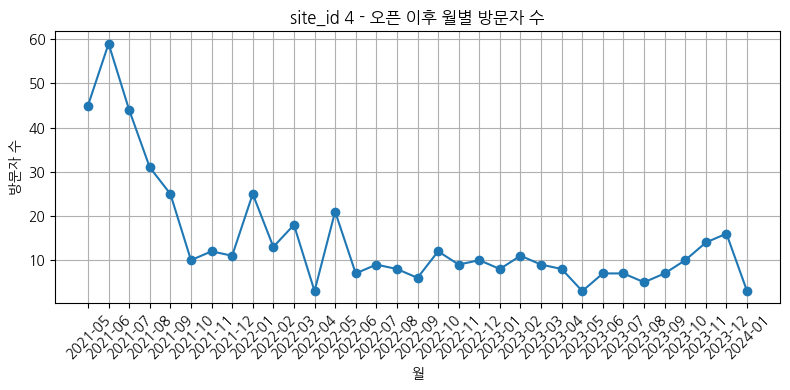

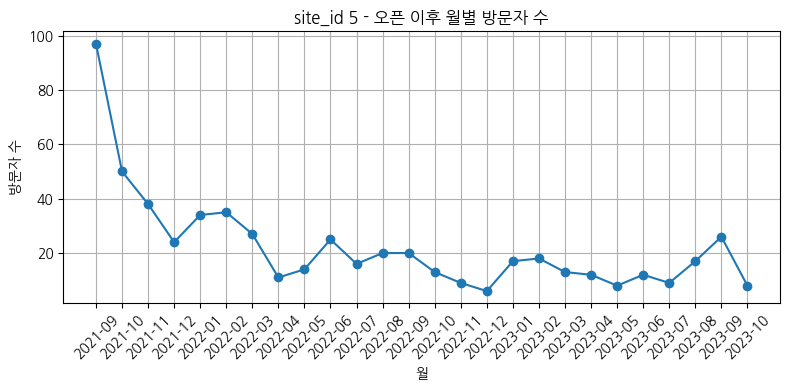

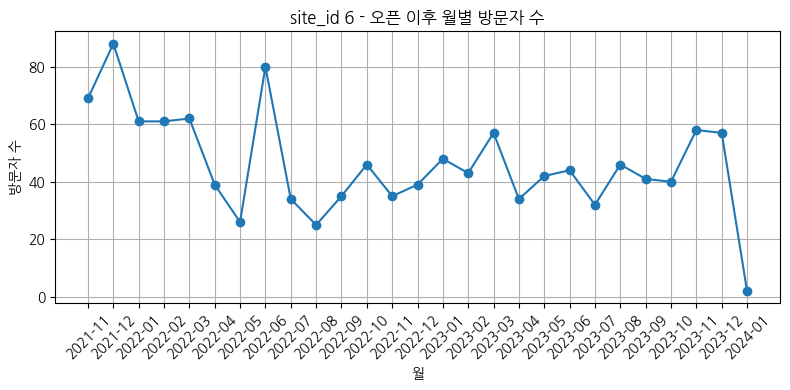

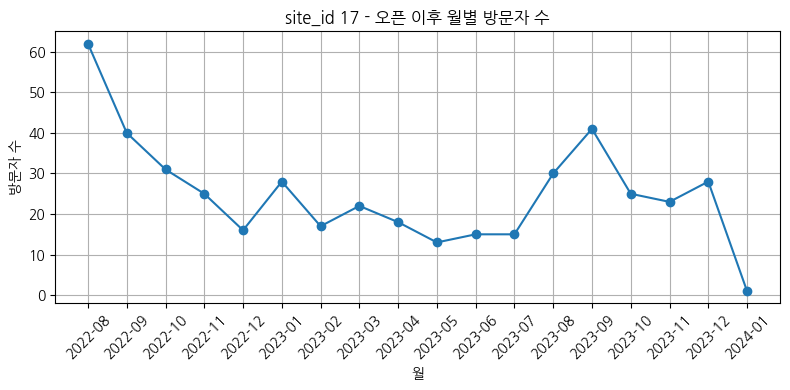

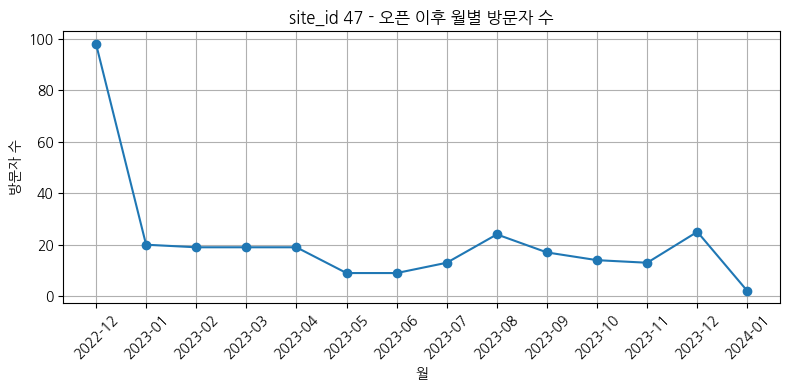

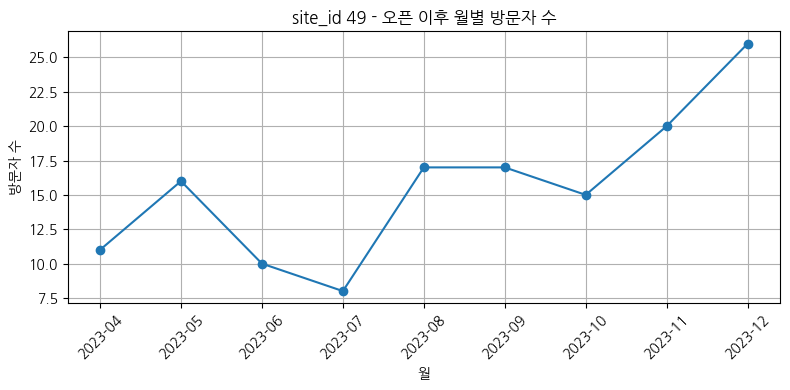

In [28]:
site_ids = filtered_visits["site_id"].unique()

for site in site_ids:
    site_df = filtered_visits[filtered_visits["site_id"] == site]
    plt.figure(figsize=(8, 4))
    plt.plot(site_df["visit_month"].astype(str), site_df["unique_visitors"], marker='o')
    plt.title(f"site_id {site} - 오픈 이후 월별 방문자 수")
    plt.xlabel("월")
    plt.ylabel("방문자 수")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

- 대부분의 지점이 오픈 이후 방문율이 높게 나왔습니다.

##### 지점 오픈 첫 달 vs 이후 방문자 수 비교

In [29]:
# 첫 방문월 및 이후 방문월 구분
first_vs_after = filtered_visits.merge(site_open_dates[["site_id", "open_month"]], on="site_id", how="left")
first_vs_after["is_open_month"] = first_vs_after["visit_month"] == first_vs_after["open_month"]

# 첫 달 방문자수
first_month_visits = (
    first_vs_after[first_vs_after["is_open_month"]]
    .groupby("site_id")["unique_visitors"]
    .first()
    .reset_index()
    .rename(columns={"unique_visitors": "open_month_visitors"})
)

# 이후 평균 방문자수
after_month_visits = (
    first_vs_after[~first_vs_after["is_open_month"]]
    .groupby("site_id")["unique_visitors"]
    .mean()
    .reset_index()
    .rename(columns={"unique_visitors": "after_avg_visitors"})
)

# 병합 후 비교
visit_compare = first_month_visits.merge(after_month_visits, on="site_id", how="left")
visit_compare["relative_ratio"] = visit_compare["open_month_visitors"] / visit_compare["after_avg_visitors"]

visit_compare

,site_id,open_month_visitors,after_avg_visitors,relative_ratio
0,4,45,13.781250,3.265306
1,5,97,19.280000,5.031120
2,6,69,45.192308,1.526809
3,17,62,22.823529,2.716495
4,47,98,15.615385,6.275862
5,49,11,16.125000,0.682171


###### 오픈 첫 달 대비 이후 방문자 평균 비율 시각화

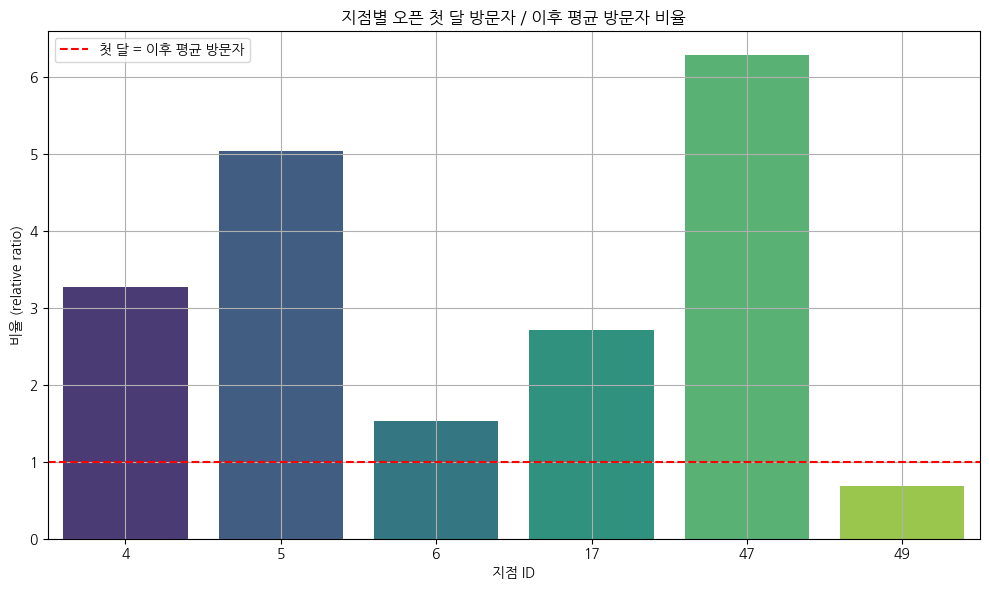

In [30]:
# 정렬 기준: 첫 달 대비 비율 높은 순
plot_data = visit_compare.sort_values("relative_ratio", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=plot_data,
    x="site_id",
    y="relative_ratio",
    palette="viridis"
)
plt.axhline(1, color='red', linestyle='--', label='첫 달 = 이후 평균 방문자')
plt.title("지점별 오픈 첫 달 방문자 / 이후 평균 방문자 비율")
plt.xlabel("지점 ID")
plt.ylabel("비율 (relative ratio)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- 지점 47: 오픈 첫 달 방문자 수가 이후 평균 대비 약 6.3배 이상으로 나타나, 오픈 초기의 마케팅이나 홍보 효과가 매우 컸던 것으로 해석됩니다.
- 지점 5, 4: 각각 약 5.1배, 3.3배로 오픈 초기에 방문이 집중된 양상을 보였습니다.
- 지점 6, 17: 방문자 비율이 1~2배 사이로, 비교적 균형 잡힌 방문 패턴을 보인 지점들입니다.
- 지점 49: 비율이 0.8 이하로, 오히려 오픈 이후에 평균 방문자가 더 많았던 지점으로 파악됩니다.

### 전환율 비교하기

In [31]:
conversion = trial_payment['is_payment'].value_counts().reset_index()

In [32]:
conversion

,is_payment,count
0,0,5995
1,1,3664


In [33]:
con = conversion.loc[conversion['is_payment'] == 1, 'count'].iloc[0]
total = conversion['count'].sum()
rate = con / total

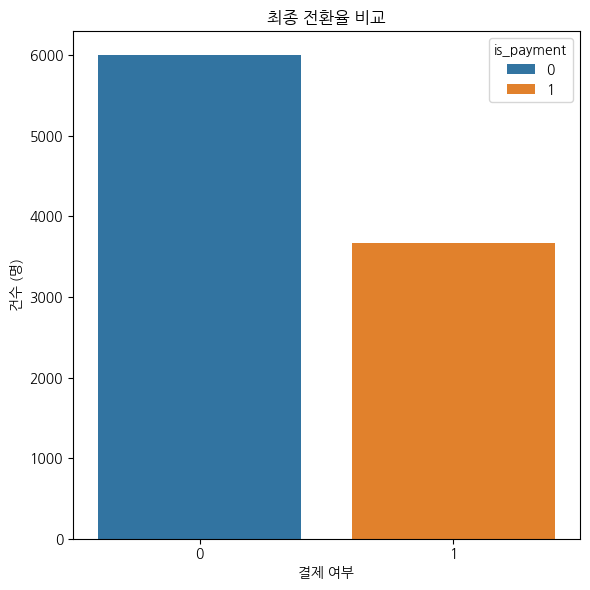

전체 유저 대비 전환율: 37.93%


In [34]:
fig, ax = plt.subplots(figsize=(6, 6))

# countplot: x에 컬럼명 문자열을, ax 인자 지정
sns.barplot(data=conversion, x='is_payment', y='count', hue='is_payment')

# 한글 레이블(선택)
ax.set_title('최종 전환율 비교')
ax.set_xlabel('결제 여부')
ax.set_ylabel('건수 (명)')

# 막대 위에 값 표시
plt.tight_layout()
plt.show()

print(f'전체 유저 대비 전환율: {rate:.2%}')

#### 방문자 전환 수

In [35]:
# 전환한 유저
converted_user_uuid = trial_payment[trial_payment['is_payment'] == 1]['user_uuid']

# 방문 기록 존재하는 결제 유저만 필터링
visited = converted_user_uuid[converted_user_uuid.isin(trial_visit_info['user_uuid'])].nunique()

print(f'방문 기록이 존재하는 결제 유저 수: {visited}명')

방문 기록이 존재하는 결제 유저 수: 2564명


#### 미방문자 전환 수

In [36]:
# 전환한 유저
converted_user_uuid = trial_payment[trial_payment['is_payment'] == 1]['user_uuid']

# 방문 기록에 없는 결제 유저만 필터링
not_visited = converted_user_uuid[~converted_user_uuid.isin(trial_visit_info['user_uuid'])].nunique()

print(f'방문 기록 없는 결제 유저 수: {not_visited}명')

방문 기록 없는 결제 유저 수: 1088명


# 모델링

## 데이터 병합

### trial_access_log 기준으로 병합 (trial_visit_info 제외)

In [37]:
# site_id 기준으로 병합
merged_df = trial_access_log.merge(site_area, on="site_id", how="left")

# area_pyeong을 site_id 바로 오른쪽으로 이동
cols = list(merged_df.columns)
# 'site_id' 다음 위치를 계산해서 'area_pyeong' 위치 조정
site_idx = cols.index("site_id")
cols.insert(site_idx + 1, cols.pop(cols.index("area_pyeong")))
merged_df = merged_df[cols]

# user_uuid 기준으로 병합
merged_df = merged_df.merge(trial_payment, on="user_uuid", how="left")

# is_payment 컬럼을 user_uuid 바로 오른쪽으로 이동
cols = list(merged_df.columns)
uuid_idx = cols.index("user_uuid")
cols.insert(uuid_idx + 1, cols.pop(cols.index("is_payment")))
merged_df = merged_df[cols]

# user_uuid 기준으로 병합
merged_df = merged_df.merge(trial_register, on="user_uuid", how="left")

# trial_date를 user_uuid 왼쪽으로 이동
cols = list(merged_df.columns)
uuid_idx = cols.index("user_uuid")
cols.insert(uuid_idx, cols.pop(cols.index("trial_date")))
merged_df = merged_df[cols]

In [38]:
# datetime 처리
merged_df["cdate"] = pd.to_datetime(merged_df["cdate"])
merged_df["trial_date"] = pd.to_datetime(merged_df["trial_date"])
merged_df["cdate"] = merged_df["cdate"].dt.tz_localize(None)

 
# 체험 신청 이후의 행동만 고려할 수도 있음 (선택)
merged_df["days_since_trial"] = (merged_df["cdate"] - merged_df["trial_date"]).dt.days

# 유저별 방문 횟수 및 입퇴실 로그 수
checkin_stats = (
    merged_df.groupby("user_uuid")
    .agg(
        total_visits=("id", "count"),
        total_checkins=("checkin", lambda x: (x == 1).sum()),
        total_checkouts=("checkin", lambda x: (x == 2).sum()),
        unique_visit_days=("cdate", lambda x: x.dt.date.nunique()),
        site_diversity=("site_id", "nunique"),
        avg_days_since_trial=("days_since_trial", "mean")
    )
)

In [39]:
checkin_stats

,total_visits,total_checkins,total_checkouts,unique_visit_days,site_diversity,avg_days_since_trial
user_uuid,,,,,,
000590dc-046f-462b-8225-4c81a97b7166,6,3,3,1,1,1.000000
000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,18,9,9,2,1,1.222222
0018e22d-a2cc-4e06-bca2-d6a041770f3b,19,11,8,2,1,1.315789
002606d9-38ca-48f3-910c-cbfada9a9109,8,4,4,2,1,1.500000
002a7570-90dd-4cab-b0aa-b0e40f7ef27a,10,5,5,1,1,1.000000
...,...,...,...,...,...,...
ffc79669-ed11-4cde-86d4-8ec232ac7b14,9,5,4,1,1,2.000000
ffcb7950-d150-40ae-a6bf-f85f5c2b9702,10,5,5,2,1,1.600000
ffce32ca-2efc-4485-b685-4b65811c2dcf,4,2,2,1,1,1.000000


### trial_visit_info 활용 파생 변수 생성

In [40]:
trial_visit_info["date"] = pd.to_datetime(trial_visit_info["date"])

visit_stats = (
    trial_visit_info.groupby("user_uuid")
    .agg(
        total_stay_days=("date", "nunique"),
        avg_stay_time=("stay_time_second", "mean"),
        max_stay_time=("stay_time_second", "max"),
        total_stay_time=("stay_time_second", "sum"),
        site_visit_diversity=("site_id", "nunique")
    )
)

In [64]:
visit_stats

,total_stay_days,avg_stay_time,max_stay_time,total_stay_time,site_visit_diversity
user_uuid,,,,,
000590dc-046f-462b-8225-4c81a97b7166,1,21417.000000,21417,21417,1
000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,3,15189.666667,25965,45569,1
0018e22d-a2cc-4e06-bca2-d6a041770f3b,2,38686.000000,42900,77372,1
002606d9-38ca-48f3-910c-cbfada9a9109,2,12512.000000,12689,25024,1
002a7570-90dd-4cab-b0aa-b0e40f7ef27a,2,11804.500000,18722,23609,1
...,...,...,...,...,...
ffc79669-ed11-4cde-86d4-8ec232ac7b14,2,17292.500000,18169,34585,1
ffcb7950-d150-40ae-a6bf-f85f5c2b9702,2,14806.500000,15154,29613,1
ffce32ca-2efc-4485-b685-4b65811c2dcf,1,8450.000000,8450,8450,1


In [41]:
# 유저 단위 결제 여부: 가장 마지막 로그 기준 (혹은 max 사용)
user_labels = (
    merged_df.groupby("user_uuid")["is_payment"]
    .max()
    .reset_index()
)

### 유저 기준 병합

In [42]:
# 통합
user_df = checkin_stats.join(visit_stats, how="outer").join(user_labels.set_index("user_uuid"))

# 결측값 처리 (활동 없는 경우 0으로 간주)
user_df = user_df.fillna(0)

In [43]:
user_df

,total_visits,total_checkins,total_checkouts,unique_visit_days,site_diversity,avg_days_since_trial,total_stay_days,avg_stay_time,max_stay_time,total_stay_time,site_visit_diversity,is_payment
user_uuid,,,,,,,,,,,,
000590dc-046f-462b-8225-4c81a97b7166,6.0,3.0,3.0,1.0,1.0,1.000000,1.0,21417.000000,21417.0,21417.0,1.0,0.0
000be14f-ba0f-4af6-bc2c-7b00dfcbc98c,18.0,9.0,9.0,2.0,1.0,1.222222,3.0,15189.666667,25965.0,45569.0,1.0,1.0
0018e22d-a2cc-4e06-bca2-d6a041770f3b,19.0,11.0,8.0,2.0,1.0,1.315789,2.0,38686.000000,42900.0,77372.0,1.0,0.0
002606d9-38ca-48f3-910c-cbfada9a9109,8.0,4.0,4.0,2.0,1.0,1.500000,2.0,12512.000000,12689.0,25024.0,1.0,0.0
002a7570-90dd-4cab-b0aa-b0e40f7ef27a,10.0,5.0,5.0,1.0,1.0,1.000000,2.0,11804.500000,18722.0,23609.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
ffc79669-ed11-4cde-86d4-8ec232ac7b14,9.0,5.0,4.0,1.0,1.0,2.000000,2.0,17292.500000,18169.0,34585.0,1.0,0.0
ffcb7950-d150-40ae-a6bf-f85f5c2b9702,10.0,5.0,5.0,2.0,1.0,1.600000,2.0,14806.500000,15154.0,29613.0,1.0,0.0
ffce32ca-2efc-4485-b685-4b65811c2dcf,4.0,2.0,2.0,1.0,1.0,1.000000,1.0,8450.000000,8450.0,8450.0,1.0,0.0


In [44]:
# 1. visit_info_df에서 시간 정보 추출
trial_visit_info["first_enter_time"] = pd.to_datetime(trial_visit_info["first_enter_time"], errors="coerce", format='mixed')
trial_visit_info["visit_hour"] = pd.to_datetime(trial_visit_info["first_enter_time"]).dt.hour
trial_visit_info["weekday"] = pd.to_datetime(trial_visit_info["date"]).dt.weekday

# 2. 시간대 플래그
trial_visit_info["is_morning"] = trial_visit_info["visit_hour"].between(6, 11)
trial_visit_info["is_evening"] = trial_visit_info["visit_hour"].between(18, 23)
trial_visit_info["is_weekend"] = trial_visit_info["weekday"].isin([5, 6])
trial_visit_info["is_office_hour"] = trial_visit_info["visit_hour"].between(9, 18)
trial_visit_info["is_late_night"] = (trial_visit_info["visit_hour"] < 6) | (trial_visit_info["visit_hour"] >= 22)

# 3. 유저별 비율 집계
time_features = trial_visit_info.groupby("user_uuid").agg(
    morning_visit_ratio=("is_morning", "mean"),
    evening_visit_ratio=("is_evening", "mean"),
    weekend_visit_ratio=("is_weekend", "mean"),
    office_hour_ratio=("is_office_hour", "mean"),
    late_night_ratio=("is_late_night", "mean")
)

In [45]:
user_df = user_df.join(time_features, how="left").fillna(0)

In [66]:
user_df.columns

Index(['total_visits', 'total_checkins', 'total_checkouts',
       'unique_visit_days', 'site_diversity', 'avg_days_since_trial',
       'total_stay_days', 'avg_stay_time', 'max_stay_time', 'total_stay_time',
       'site_visit_diversity', 'is_payment', 'morning_visit_ratio',
       'evening_visit_ratio', 'weekend_visit_ratio', 'office_hour_ratio',
       'late_night_ratio'],
      dtype='object')

## RandomForest

```
# 기존 (현진님 피쳐 추가 전)

              precision    recall  f1-score   support

         0.0       0.69      0.77      0.73       840
         1.0       0.48      0.38      0.42       468

    accuracy                           0.63      1308
   macro avg       0.58      0.57      0.58      1308
weighted avg       0.61      0.63      0.62      1308

```

### 기본 모델

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = user_df.drop(columns="is_payment")
y = user_df["is_payment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42, class_weight="balanced")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.69      0.82      0.75       840
         1.0       0.52      0.35      0.42       468

    accuracy                           0.65      1308
   macro avg       0.61      0.59      0.59      1308
weighted avg       0.63      0.65      0.63      1308



```
# 기존 (현진님 피쳐 추가 전)

                 feature  importance
0          max_stay_time    0.207299
1          avg_stay_time    0.204645
2        total_stay_time    0.198616
3   avg_days_since_trial    0.086409
4           total_visits    0.084404
5         total_checkins    0.064889
6        total_checkouts    0.063427
7      unique_visit_days    0.033567
8        total_stay_days    0.033285
9         site_diversity    0.015997
10  site_visit_diversity    0.007463
```

In [47]:
# 피처 중요도 추출
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance = feature_importance.sort_values(ascending=False)

# 중요도 테이블 출력
importance_df = feature_importance.reset_index()
importance_df.columns = ["feature", "importance"]
print(importance_df)

                 feature  importance
0          avg_stay_time    0.172688
1          max_stay_time    0.170049
2        total_stay_time    0.163814
3           total_visits    0.079064
4   avg_days_since_trial    0.078951
5         total_checkins    0.070257
6        total_checkouts    0.060982
7       late_night_ratio    0.034642
8    weekend_visit_ratio    0.032403
9    evening_visit_ratio    0.031580
10       total_stay_days    0.030677
11     unique_visit_days    0.024001
12     office_hour_ratio    0.020606
13        site_diversity    0.014332
14   morning_visit_ratio    0.009377
15  site_visit_diversity    0.006577


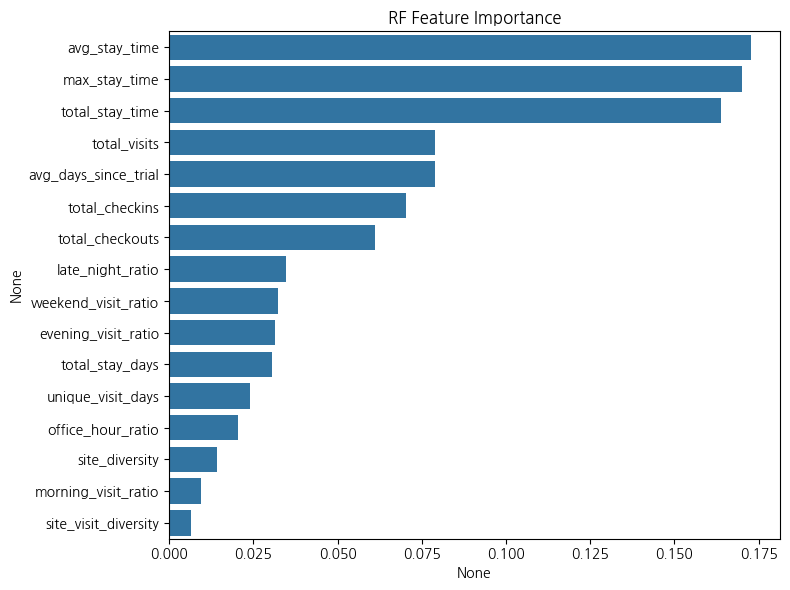

In [48]:
feat_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("RF Feature Importance")
plt.tight_layout()
plt.show()

### SMOTE 적용

In [49]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

model_sm = RandomForestClassifier(random_state=42)
model_sm.fit(X_res, y_res)
print(classification_report(y_test, model_sm.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.71      0.74      0.72       840
         1.0       0.49      0.44      0.47       468

    accuracy                           0.64      1308
   macro avg       0.60      0.59      0.59      1308
weighted avg       0.63      0.64      0.63      1308



In [50]:
# 피처 중요도 추출
feature_importance = pd.Series(model_sm.feature_importances_, index=X.columns)
feature_importance = feature_importance.sort_values(ascending=False)

# 중요도 테이블 출력
importance_df = feature_importance.reset_index()
importance_df.columns = ["feature", "importance"]
print(importance_df)

                 feature  importance
0          avg_stay_time    0.142563
1          max_stay_time    0.138264
2        total_stay_time    0.134212
3   avg_days_since_trial    0.093449
4         total_checkins    0.069817
5    evening_visit_ratio    0.068405
6           total_visits    0.065011
7        total_checkouts    0.063539
8       late_night_ratio    0.055213
9    weekend_visit_ratio    0.051085
10     unique_visit_days    0.031898
11     office_hour_ratio    0.026868
12       total_stay_days    0.026724
13        site_diversity    0.014296
14   morning_visit_ratio    0.009547
15  site_visit_diversity    0.009109


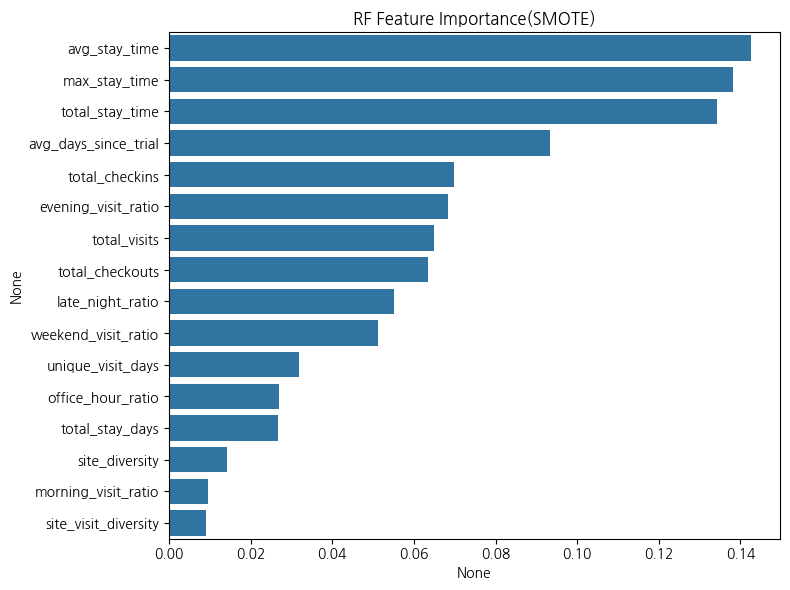

In [51]:
feat_imp = pd.Series(model_sm.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("RF Feature Importance(SMOTE)")
plt.tight_layout()
plt.show()

### 하이퍼파라미터 튜닝

In [52]:
from sklearn.model_selection import GridSearchCV

```python
# 튜닝할 파라미터 그리드 정의
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
}

# 랜덤 포레스트 모델 객체
rf_base = RandomForestClassifier(random_state=42, class_weight="balanced")

# GridSearchCV 객체 생성
grid_search = GridSearchCV(estimator=rf_base, param_grid=param_grid, scoring="roc_auc", cv=3, n_jobs=-1, verbose=2)

# 하이퍼파라미터 튜닝 실행
grid_search.fit(X_res, y_res)

# 최적 모델 추출
best_rf = grid_search.best_estimator_

print("✅ 최적 하이퍼파라미터:")
print(grid_search.best_params_)
```

```python
# 튜닝할 파라미터 그리드 정의
param_grid = {
    "n_estimators": [200, 300, 400],
    "max_depth": [20, 30, 40],
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt"],
}

# 랜덤 포레스트 모델 객체
rf_base = RandomForestClassifier(random_state=42, class_weight="balanced")

# GridSearchCV 객체 생성
grid_search = GridSearchCV(estimator=rf_base, param_grid=param_grid, scoring="roc_auc", cv=3, n_jobs=-1, verbose=2)

# 하이퍼파라미터 튜닝 실행
grid_search.fit(X_res, y_res)

# 최적 모델 추출
best_rf = grid_search.best_estimator_

print("✅ 최적 하이퍼파라미터:")
print(grid_search.best_params_)
```

In [53]:
# 튜닝할 파라미터 그리드 정의
param_grid = {
    "n_estimators": [550],
    "max_depth": [20],
    "min_samples_split": [2],
    "min_samples_leaf": [1],
    "max_features": ["sqrt"],
}

# 랜덤 포레스트 모델 객체
rf_base = RandomForestClassifier(random_state=42, class_weight="balanced")

# GridSearchCV 객체 생성
grid_search = GridSearchCV(estimator=rf_base, param_grid=param_grid, scoring="roc_auc", cv=3, n_jobs=-1, verbose=2)

# 하이퍼파라미터 튜닝 실행
grid_search.fit(X_res, y_res)

# 최적 모델 추출
best_rf = grid_search.best_estimator_

print("✅ 최적 하이퍼파라미터:")
print(grid_search.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
✅ 최적 하이퍼파라미터:
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 550}


In [54]:
# 테스트셋에 대해 예측 수행
y_pred = best_rf.predict(X_test)

# classification report 출력
print(classification_report(y_test, y_pred, digits=2))

              precision    recall  f1-score   support

         0.0       0.71      0.74      0.73       840
         1.0       0.50      0.45      0.47       468

    accuracy                           0.64      1308
   macro avg       0.60      0.60      0.60      1308
weighted avg       0.63      0.64      0.64      1308



```
# 튜닝 전

              precision    recall  f1-score   support

         0.0       0.71      0.74      0.72       840
         1.0       0.49      0.44      0.46       468

    accuracy                           0.64      1308
   macro avg       0.60      0.59      0.59      1308
weighted avg       0.63      0.64      0.63      1308
```

1. Accuracy (정확도)
    - 튜닝 전: 0.64
    - 튜닝 후: 0.63
        
        → 0.01 하락

2. 클래스별 성능 비교
- 클래스 0.0 (비가입 예측)

|지표|튜닝 전|튜닝 후|변화|
|---|---|---|---|
|Precision|0.70|0.71|▲ +0.01|
|Recall|0.75|0.74|▼ -0.01|
|F1-score|0.72|0.72|→ 동일|

- 클래스 1.0 (가입 예측 - 소수 클래스)

|지표|튜닝 전|튜닝 후|변화|
|---|---|---|---|
|Precision|0.48|0.49|▲ +0.01|
|Recall|0.42|0.44|▲ +0.02|
|F1-score|0.45|0.46|▲ +0.01|

3. 평균 성능 (Macro / Weighted Avg)

|지표|튜닝 전|튜닝 후|변화|
|---|---|---|---|
|Macro F1|0.59|0.59|→ 동일|
|Weighted F1|0.63|0.63|→ 동일|

- 해석 요약
    - 튜닝 후 약간의 성능 향상이 있으나 전반적으로 큰 변화는 없음
    - 특히 가입 예측 클래스(1.0)의 recall이 소폭 향상되었지만, 여전히 precision과 recall 모두 낮아 소수 클래스 예측 성능이 부족함
    - Macro 평균이 그대로인 점을 보면 모든 클래스에 대한 전반적인 균형 개선은 아직 미미함

- 다음 개선 방향 제안
    - 리콜 중심의 threshold 조정 (특히 클래스 1.0의 민감도 중요 시)
    - 앙상블 기법 도입: 예) RandomForest + XGBoost soft voting
    - 더 많은 파생 변수(feature engineering) 생성

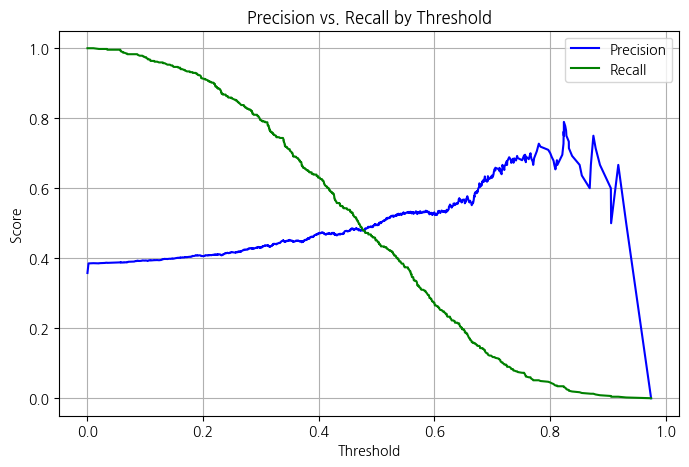

In [55]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# 양성 클래스 확률 예측
y_scores = best_rf.predict_proba(X_test)[:, 1]

# precision, recall, threshold 계산
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Precision vs. Recall by Threshold plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], label="Precision", color="b")
plt.plot(thresholds, recalls[:-1], label="Recall", color="g")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision vs. Recall by Threshold")
plt.legend()
plt.grid()
plt.show()

🎯 Precision이 중요한 경우
예측한 “결제할 사람” 중 실제 결제자가 정확하게 맞아야 하는 경우

예: 타겟 오퍼 비용이 비싸다거나, 상담 리소스가 한정되어 잘못 추천되면 낭비되는 경우

🎯 Recall이 중요한 경우
실제 결제할 사람을 최대한 많이 잡아야 하는 경우

예: 전환율 자체를 끌어올리는 게 더 중요하거나, 놓치는 고객이 기회비용이 크다고 판단될 때

- Precision 백화점 (VIP 쿠폰)

- Recall 테무 알리 (전 회원 쿠폰)

- 어차피 하고 있는 프로모션이니깐 해당 프로모션의 전환률을 높이자
    - Recall 높이자

In [56]:
# 확률 예측
y_proba = best_rf.predict_proba(X_test)[:, 1]

# Threshold = 0.41로 조정
y_pred_threshold = (y_proba >= 0.41).astype(int)

# classification report 출력
print(classification_report(y_test, y_pred_threshold, digits=2))

              precision    recall  f1-score   support

         0.0       0.74      0.62      0.67       840
         1.0       0.47      0.61      0.53       468

    accuracy                           0.61      1308
   macro avg       0.60      0.61      0.60      1308
weighted avg       0.64      0.61      0.62      1308



## XGB

In [57]:
from xgboost import XGBClassifier

# XGBoost 모델 정의
xgb_sm = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

# SMOTE로 오버샘플링된 데이터로 학습
xgb_sm.fit(X_res, y_res)

# 테스트 데이터에 대해 예측 및 성능 평가
y_pred_xgb = xgb_sm.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

         0.0       0.70      0.77      0.73       840
         1.0       0.49      0.39      0.44       468

    accuracy                           0.64      1308
   macro avg       0.59      0.58      0.58      1308
weighted avg       0.62      0.64      0.63      1308



### 하이퍼파라미터 튜닝

```python
# 튜닝할 파라미터 그리드 정의
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# XGBClassifier 객체 생성
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

# GridSearchCV 객체 생성
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    verbose=2,
    n_jobs=-1
)

# SMOTE 적용된 데이터로 학습
grid_search.fit(X_res, y_res)

# 최적 모델 및 파라미터 출력
best_xgb = grid_search.best_estimator_
print("✅ 최적 하이퍼파라미터:")
print(grid_search.best_params_)
```

```
✅ 최적 하이퍼파라미터:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
```

```python
# 튜닝할 파라미터 그리드 정의
param_grid = {
    "n_estimators": [200, 300, 400],
    "max_depth": [7, 9, 11],
    "learning_rate": [0.1, 0.2],
    "subsample": [0.6, 0,7, 0.8],
    "colsample_bytree": [1.0]
}

# XGBClassifier 객체 생성
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

# GridSearchCV 객체 생성
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    verbose=2,
    n_jobs=-1
)

# SMOTE 적용된 데이터로 학습
grid_search.fit(X_res, y_res)

# 최적 모델 및 파라미터 출력
best_xgb = grid_search.best_estimator_
print("✅ 최적 하이퍼파라미터:")
print(grid_search.best_params_)
```

```
✅ 최적 하이퍼파라미터:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
```

```python
# 튜닝할 파라미터 그리드 정의
param_grid = {
    "n_estimators": [200],
    "max_depth": [7],
    "learning_rate": [0.1],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [1.0]
}

# XGBClassifier 객체 생성
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

# GridSearchCV 객체 생성
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    verbose=2,
    n_jobs=-1
)

# SMOTE 적용된 데이터로 학습
grid_search.fit(X_res, y_res)

# 최적 모델 및 파라미터 출력
best_xgb = grid_search.best_estimator_
print("✅ 최적 하이퍼파라미터:")
print(grid_search.best_params_)
```

```
✅ 최적 하이퍼파라미터:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
```

### best_xgb

In [58]:
# 튜닝할 파라미터 그리드 정의
param_grid = {
    "n_estimators": [200],
    "max_depth": [7],
    "learning_rate": [0.1],
    "subsample": [0.8],
    "colsample_bytree": [1.0]
}

# XGBClassifier 객체 생성
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

# GridSearchCV 객체 생성
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    verbose=2,
    n_jobs=-1
)

# SMOTE 적용된 데이터로 학습
grid_search.fit(X_res, y_res)

# 최적 모델 및 파라미터 출력
best_xgb = grid_search.best_estimator_
print("✅ 최적 하이퍼파라미터:")
print(grid_search.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
✅ 최적 하이퍼파라미터:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


### 고급 파라미터 추가 튜닝

```python
param_grid_refined = {
    "min_child_weight": [1, 5, 10],
    "gamma": [0, 1, 5],
    "reg_alpha": [0, 0.1, 1],
    "reg_lambda": [1, 5, 10]
}

xgb_refined = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    colsample_bytree=1.0,
    learning_rate=0.1,
    max_depth=7,
    n_estimators=200,
    subsample=0.8
)

grid_search_refined = GridSearchCV(
    estimator=xgb_refined,
    param_grid=param_grid_refined,
    scoring="roc_auc",
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_refined.fit(X_res, y_res)

best_xgb_refined = grid_search_refined.best_estimator_
print("🎯 정규화 파라미터 포함 최적 조합:")
print(grid_search_refined.best_params_)
```

```
🎯 정규화 파라미터 포함 최적 조합:
{'gamma': 1, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 1}
```

In [59]:
param_grid_refined = {
    "min_child_weight": [1],
    "gamma": [1],
    "reg_alpha": [0],
    "reg_lambda": [1]
}

xgb_refined = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    colsample_bytree=1.0,
    learning_rate=0.1,
    max_depth=7,
    n_estimators=200,
    subsample=0.8
)

grid_search_refined = GridSearchCV(
    estimator=xgb_refined,
    param_grid=param_grid_refined,
    scoring="roc_auc",
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_refined.fit(X_res, y_res)

best_xgb_refined = grid_search_refined.best_estimator_
print("🎯 정규화 파라미터 포함 최적 조합:")
print(grid_search_refined.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
🎯 정규화 파라미터 포함 최적 조합:
{'gamma': 1, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 1}


In [60]:
# 테스트셋에 대해 예측 수행
y_pred = best_xgb_refined.predict(X_test)

# classification report 출력
print(classification_report(y_test, y_pred, digits=2))

              precision    recall  f1-score   support

         0.0       0.71      0.78      0.74       840
         1.0       0.51      0.42      0.46       468

    accuracy                           0.65      1308
   macro avg       0.61      0.60      0.60      1308
weighted avg       0.64      0.65      0.64      1308



## RandomForest + XGBoost soft voting

In [61]:
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Soft Voting Classifier 생성
voting_clf = VotingClassifier(
    estimators=[("rf", best_rf), ("xgb", best_xgb_refined)],
    voting="soft"
)

# 학습
voting_clf.fit(X_train, y_train)

# 예측 및 평가
y_pred = voting_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.70      0.80      0.75       840
         1.0       0.51      0.37      0.43       468

    accuracy                           0.65      1308
   macro avg       0.60      0.59      0.59      1308
weighted avg       0.63      0.65      0.63      1308



### best_rf와 비교 (모델 확정 best_rf)

```
              precision    recall  f1-score   support

         0.0       0.74      0.62      0.67       840
         1.0       0.47      0.61      0.53       468

    accuracy                           0.61      1308
   macro avg       0.60      0.61      0.60      1308
weighted avg       0.64      0.61      0.62      1308
```

- best_rf 선택 이유
    - 3일 무료체험 프로모션 (이미 진행 중)
    - 데이터셋 (3일 무료체험 신청 이전의 행동 알 수 없음)
    - 이미 진행 중인 프로모션 + 이전 행동 알 수 없음
        - 진행 중인 프로모션 내에서 결제로의 전환률을 높이는 방향으로 모델 개선
    
- XGB, soft voting 기각 이유
    - 정확도와 평균 성능은 약간 상승했지만
    - 랜덤포레스트 모델에 비해 Recall보다는 Precision에 더 높은 수치를 보임
    - 예측하고자 하는 방향성과 맞지 않음

- Recall 중점(테무 알리 전 회원 쿠폰): 실제 결제할 사람을 최대한 많이 붙잡자!
    - 어차피 하고 있는 프로모션이니 해당 프로모션 내에서 전환률을 높이는 것을 목적으로